<a href="https://colab.research.google.com/github/SalimZ04/AI_GAME_FUN/blob/main/Football_IQ_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

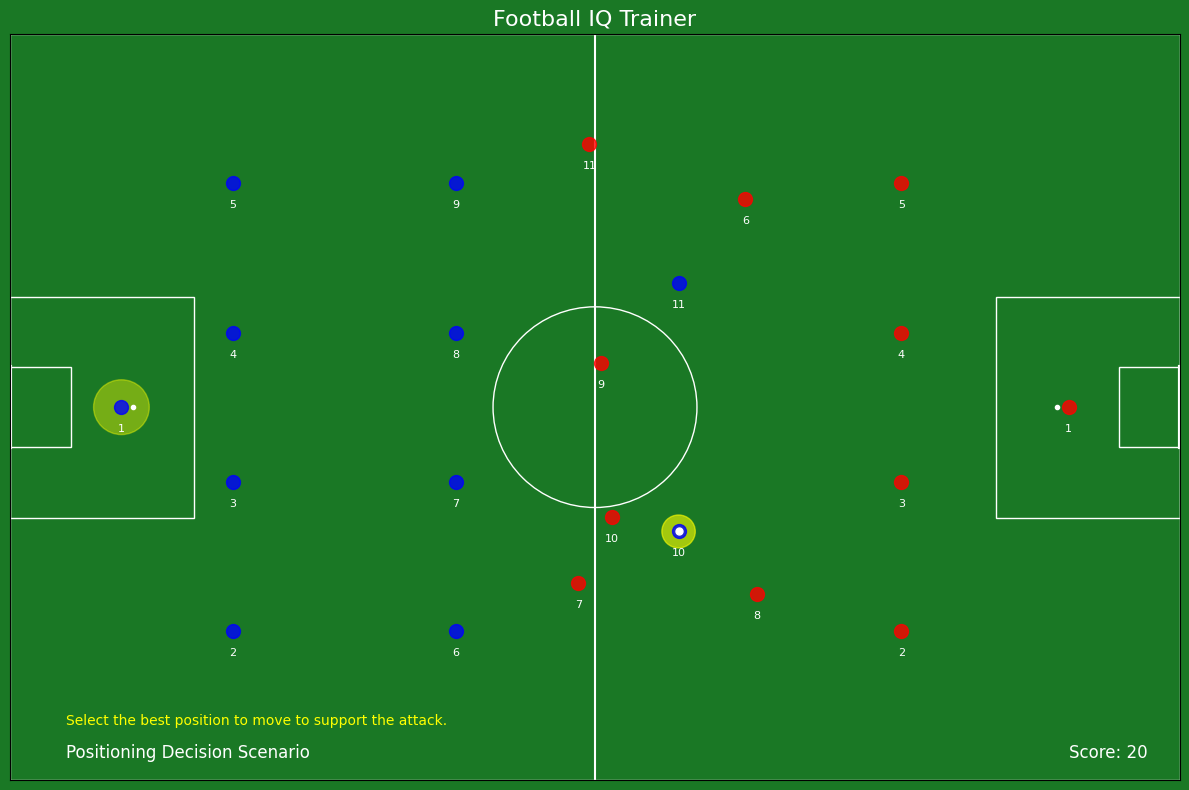

GridBox(children=(Button(description='Move to position (25.0, 27.0)', layout=Layout(height='40px', width='200p…

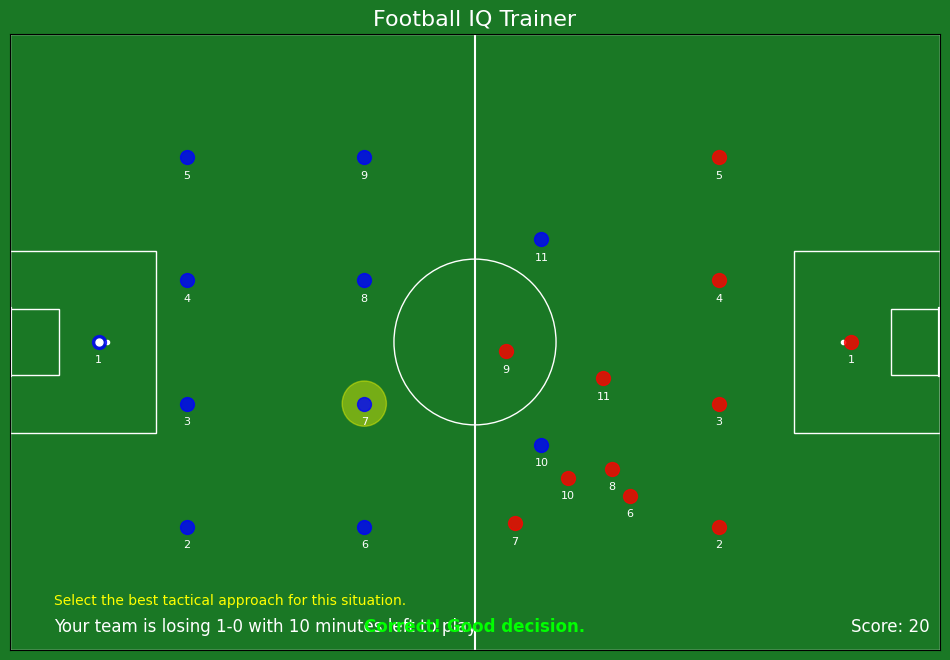

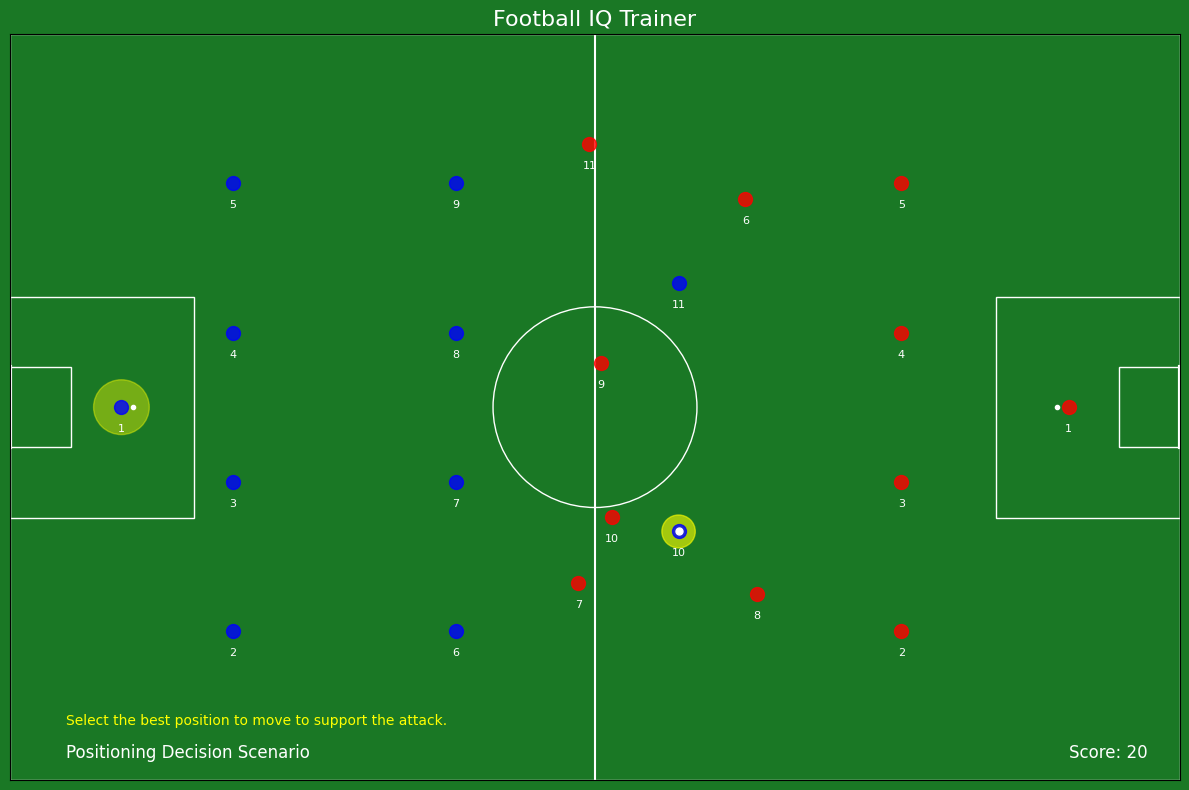

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import random
import time
from google.colab import output
import ipywidgets as widgets
from IPython.display import clear_output

class FootballField:
    def __init__(self):
        self.length = 105  # meters
        self.width = 68  # meters
        self.setup_field()

    def setup_field(self):
        # Create a new figure each time
        self.fig, self.ax = plt.subplots(figsize=(12, 8))

        # Draw the field
        self.ax.set_xlim(0, self.length)
        self.ax.set_ylim(0, self.width)

        # Field color
        rect = patches.Rectangle((0, 0), self.length, self.width, linewidth=1,
                                edgecolor='white', facecolor='#1a7825')
        self.ax.add_patch(rect)

        # Center line
        self.ax.plot([self.length/2, self.length/2], [0, self.width], 'white')

        # Center circle
        center_circle = patches.Circle((self.length/2, self.width/2), 9.15,
                                     fill=False, color='white')
        self.ax.add_patch(center_circle)

        # Goal areas
        left_goal = patches.Rectangle((0, self.width/2 - 7.32/2), 5.5, 7.32,
                                    linewidth=1, edgecolor='white',
                                    facecolor='none')
        right_goal = patches.Rectangle((self.length - 5.5, self.width/2 - 7.32/2),
                                     5.5, 7.32, linewidth=1, edgecolor='white',
                                     facecolor='none')
        self.ax.add_patch(left_goal)
        self.ax.add_patch(right_goal)

        # Penalty areas
        left_penalty = patches.Rectangle((0, self.width/2 - 20.16/2), 16.5, 20.16,
                                       linewidth=1, edgecolor='white',
                                       facecolor='none')
        right_penalty = patches.Rectangle((self.length - 16.5, self.width/2 - 20.16/2),
                                        16.5, 20.16, linewidth=1, edgecolor='white',
                                        facecolor='none')
        self.ax.add_patch(left_penalty)
        self.ax.add_patch(right_penalty)

        # Penalty spots
        self.ax.plot(11, self.width/2, 'o', color='white', markersize=3)
        self.ax.plot(self.length - 11, self.width/2, 'o', color='white', markersize=3)

        # Goal posts
        self.ax.plot([0, 0], [self.width/2 - 7.32/2, self.width/2 + 7.32/2], 'white', linewidth=3)
        self.ax.plot([self.length, self.length],
                   [self.width/2 - 7.32/2, self.width/2 + 7.32/2], 'white', linewidth=3)

        # Remove axis ticks
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title('Football IQ Trainer', fontsize=16, color='white')
        self.fig.set_facecolor('#1a7825')

        self.ax.grid(False)

class Player:
    def __init__(self, x, y, team, number, role=None):
        self.x = x
        self.y = y
        self.team = team  # 'blue' or 'red'
        self.number = number
        self.role = role
        self.has_ball = False
        self.color = 'blue' if team == 'blue' else 'red'

    def move(self, dx, dy, field_limits):
        new_x = self.x + dx
        new_y = self.y + dy

        # Ensure the player stays within field boundaries
        new_x = max(0, min(new_x, field_limits[0]))
        new_y = max(0, min(new_y, field_limits[1]))

        self.x = new_x
        self.y = new_y

    def distance_to(self, x, y):
        return np.sqrt((self.x - x) ** 2 + (self.y - y) ** 2)

    def draw(self, ax):
        # Draw the player as a circle
        ax.plot(self.x, self.y, 'o', color=self.color, markersize=10, alpha=0.8)
        # Add player number
        ax.text(self.x, self.y - 2, str(self.number), color='white',
               ha='center', va='center', fontsize=8)

        # Highlight if player has the ball
        if self.has_ball:
            ball_highlight = patches.Circle((self.x, self.y), 1.5,
                                         color='yellow', alpha=0.6)
            ax.add_patch(ball_highlight)

class Ball:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.possessor = None

    def move_to(self, x, y):
        self.x = x
        self.y = y

    def give_to_player(self, player):
        self.possessor = player
        player.has_ball = True
        self.x = player.x
        self.y = player.y

    def draw(self, ax):
        ax.plot(self.x, self.y, 'o', color='white', markersize=5, alpha=1.0)

class FootballScenario:
    def __init__(self, field):
        self.field = field
        self.players_blue = []
        self.players_red = []
        self.ball = Ball(field.length/2, field.width/2)
        self.active_player = None  # Player controlled by user
        self.scenario_description = ""
        self.current_task = ""
        self.feedback = ""
        self.score = 0
        self.timer = 15  # seconds for decision making
        self.scenario_type = None
        self.options = []
        self.correct_option = None

    def setup_players(self, formation='4-4-2'):
        # Clear existing players
        self.players_blue = []
        self.players_red = []

        # Add goalkeeper
        self.players_blue.append(Player(10, self.field.width/2, 'blue', 1, 'GK'))

        if formation == '4-4-2':
            # Add defenders
            self.players_blue.append(Player(20, self.field.width/5, 'blue', 2, 'DEF'))
            self.players_blue.append(Player(20, 2*self.field.width/5, 'blue', 3, 'DEF'))
            self.players_blue.append(Player(20, 3*self.field.width/5, 'blue', 4, 'DEF'))
            self.players_blue.append(Player(20, 4*self.field.width/5, 'blue', 5, 'DEF'))

            # Add midfielders
            self.players_blue.append(Player(40, self.field.width/5, 'blue', 6, 'MID'))
            self.players_blue.append(Player(40, 2*self.field.width/5, 'blue', 7, 'MID'))
            self.players_blue.append(Player(40, 3*self.field.width/5, 'blue', 8, 'MID'))
            self.players_blue.append(Player(40, 4*self.field.width/5, 'blue', 9, 'MID'))

            # Add forwards
            self.players_blue.append(Player(60, self.field.width/3, 'blue', 10, 'FWD'))
            self.players_blue.append(Player(60, 2*self.field.width/3, 'blue', 11, 'FWD'))

        # Add opponent players
        self.players_red.append(Player(95, self.field.width/2, 'red', 1, 'GK'))

        # Defenders
        self.players_red.append(Player(80, self.field.width/5, 'red', 2, 'DEF'))
        self.players_red.append(Player(80, 2*self.field.width/5, 'red', 3, 'DEF'))
        self.players_red.append(Player(80, 3*self.field.width/5, 'red', 4, 'DEF'))
        self.players_red.append(Player(80, 4*self.field.width/5, 'red', 5, 'DEF'))

        # Add midfielders and forwards based on scenario
        for i in range(6):
            x = 60 + random.randint(-10, 10)
            y = random.randint(10, self.field.width-10)
            self.players_red.append(Player(x, y, 'red', i+6, 'MID' if i < 3 else 'FWD'))

    def draw_scene(self):
        # Re-setup the field (creates new figure)
        self.field.setup_field()

        # Draw all players
        for player in self.players_blue + self.players_red:
            player.draw(self.field.ax)

        # Draw the ball
        self.ball.draw(self.field.ax)

        # Draw the current task
        self.field.ax.text(5, 2, self.scenario_description, color='white', fontsize=12)
        self.field.ax.text(5, 5, self.current_task, color='yellow', fontsize=10)

        if self.feedback:
            self.field.ax.text(self.field.length/2, 2, self.feedback,
                             color='lime' if 'Correct' in self.feedback else 'orange',
                             fontsize=12, ha='center', fontweight='bold')

        # Draw timer if applicable
        if self.timer < 15:
            self.field.ax.text(self.field.length-10, 5, f"Time: {self.timer}s",
                             color='white', fontsize=12)

        # Draw score
        self.field.ax.text(self.field.length-10, 2, f"Score: {self.score}",
                         color='white', fontsize=12)

        if self.active_player:
            # Highlight active player
            active_highlight = patches.Circle((self.active_player.x, self.active_player.y),
                                           2.5, color='yellow', alpha=0.4)
            self.field.ax.add_patch(active_highlight)

            # Draw possible passes if this is a passing scenario
            if self.scenario_type == 'passing':
                for player in self.players_blue:
                    if player != self.active_player:
                        # Draw line to show possible pass
                        self.field.ax.plot([self.active_player.x, player.x],
                                         [self.active_player.y, player.y],
                                         'y--', alpha=0.3)

    def generate_passing_scenario(self):
        self.setup_players()
        self.scenario_type = 'passing'
        self.scenario_description = "Passing Decision Scenario"

        # Choose a random midfielder or forward to be the active player
        eligible_players = [p for p in self.players_blue
                          if p.role in ['MID', 'FWD']]
        self.active_player = random.choice(eligible_players)
        self.ball.give_to_player(self.active_player)

        # Position some opponents around the active player
        for i in range(3):
            defender = random.choice(self.players_red)
            defender.x = self.active_player.x + random.randint(-8, 8)
            defender.y = self.active_player.y + random.randint(-8, 8)

        # Generate passing options
        pass_targets = [p for p in self.players_blue if p != self.active_player]

        # Create difficulty ratings for each pass
        pass_difficulties = []
        for target in pass_targets:
            # Calculate distance
            distance = self.active_player.distance_to(target.x, target.y)

            # Check for opponents in passing lane
            pass_blocked = False
            for opponent in self.players_red:
                # Simple check if opponent is in the passing lane
                if self.point_in_rectangle(opponent.x, opponent.y,
                                         self.active_player.x, self.active_player.y,
                                         target.x, target.y, 5):
                    pass_blocked = True
                    break

            # Score based on distance, blocking, and target's position
            difficulty = distance * 0.1  # Distance factor
            if pass_blocked:
                difficulty += 20

            # Lower difficulty for forwards in good positions
            if target.role == 'FWD' and target.x > 70:
                difficulty -= 15

            pass_difficulties.append((target, difficulty))

        # Sort by difficulty (lower is better)
        pass_difficulties.sort(key=lambda x: x[1])

        # Select 4 options including the best one
        best_option = pass_difficulties[0][0]
        self.options = []

        # Add top 3 passes and one random bad option
        for i in range(min(3, len(pass_difficulties))):
            self.options.append(pass_difficulties[i][0])

        # Add a bad option if we have less than 4
        if len(self.options) < 4 and len(pass_difficulties) > 3:
            self.options.append(pass_difficulties[-1][0])

        # Shuffle options
        random.shuffle(self.options)

        # Set correct option
        self.correct_option = best_option

        self.current_task = "Select the best passing option based on the current situation."
        self.timer = 15
        self.feedback = ""

    def generate_positioning_scenario(self):
        self.setup_players()
        self.scenario_type = 'positioning'
        self.scenario_description = "Positioning Decision Scenario"

        # Choose a random player to be the active player
        self.active_player = random.choice(self.players_blue)

        # Position the ball with a teammate
        ball_carrier = random.choice([p for p in self.players_blue if p != self.active_player])
        self.ball.give_to_player(ball_carrier)

        # Generate possible positions for player to move to
        possible_positions = []

        # Create 4 possible positions with different strategic values
        for _ in range(4):
            new_x = self.active_player.x + random.randint(-15, 15)
            new_y = self.active_player.y + random.randint(-15, 15)

            # Keep within field limits
            new_x = max(5, min(new_x, self.field.length - 5))
            new_y = max(5, min(new_y, self.field.width - 5))

            # Calculate position value
            position_value = 0

            # Better to be further up the field
            position_value += (new_x - self.active_player.x) * 0.5

            # Check if position creates passing lane from ball carrier
            passing_lane_clear = True
            for opponent in self.players_red:
                if self.point_in_rectangle(opponent.x, opponent.y,
                                         ball_carrier.x, ball_carrier.y,
                                         new_x, new_y, 3):
                    passing_lane_clear = False
                    break

            if passing_lane_clear:
                position_value += 30

            # Check proximity to opponents
            for opponent in self.players_red:
                dist = np.sqrt((new_x - opponent.x)**2 + (new_y - opponent.y)**2)
                if dist < 5:
                    position_value -= 20

            possible_positions.append(((new_x, new_y), position_value))

        # Sort by position value
        possible_positions.sort(key=lambda x: x[1], reverse=True)

        self.options = [pos[0] for pos in possible_positions]
        self.correct_option = possible_positions[0][0]

        self.current_task = "Select the best position to move to support the attack."
        self.timer = 15
        self.feedback = ""

    def generate_tactical_scenario(self):
        self.setup_players()
        self.scenario_type = 'tactical'
        self.scenario_description = "Tactical Decision Scenario"

        # Set up a specific tactical situation
        situations = [
            "Your team is losing 1-0 with 10 minutes left to play.",
            "Your team is winning 1-0 with 5 minutes left to play.",
            "Your team has a player sent off and is down to 10 men.",
            "The opposition is pressing high up the pitch.",
            "The opposition is sitting deep in a defensive block."
        ]

        self.scenario_description = random.choice(situations)

        # Generate tactical options
        tactical_options = [
            "Push more players forward to attack",
            "Maintain possession and control the tempo",
            "Counter-attack with quick transitions",
            "Press aggressively to win the ball back",
            "Sit deep and defend compactly"
        ]

        # Choose the best option based on the situation
        situation_to_best_tactic = {
            "Your team is losing 1-0 with 10 minutes left to play.": "Push more players forward to attack",
            "Your team is winning 1-0 with 5 minutes left to play.": "Maintain possession and control the tempo",
            "Your team has a player sent off and is down to 10 men.": "Sit deep and defend compactly",
            "The opposition is pressing high up the pitch.": "Counter-attack with quick transitions",
            "The opposition is sitting deep in a defensive block.": "Maintain possession and control the tempo"
        }

        self.correct_option = situation_to_best_tactic[self.scenario_description]

        # Select 4 random options including the correct one
        other_options = [opt for opt in tactical_options if opt != self.correct_option]
        selected_options = random.sample(other_options, 3)
        selected_options.append(self.correct_option)
        random.shuffle(selected_options)

        self.options = selected_options

        self.current_task = "Select the best tactical approach for this situation."
        self.timer = 15
        self.feedback = ""

    def check_answer(self, selected_option):
        if selected_option == self.correct_option:
            self.score += 10
            self.feedback = "Correct! Good decision."
            return True
        else:
            # Calculate feedback
            if self.scenario_type == 'passing':
                self.feedback = f"Not the best option. Player {self.correct_option.number} was in a better position."
            elif self.scenario_type == 'positioning':
                self.feedback = "Not the best position. Consider space and passing lanes."
            else:
                self.feedback = f"Not the best tactic. Consider: {self.correct_option}"
            return False

    def point_in_rectangle(self, px, py, x1, y1, x2, y2, width):
        # Check if a point (px, py) is within a rectangle defined by
        # the line from (x1, y1) to (x2, y2) with a width

        # Vector from (x1, y1) to (x2, y2)
        vx, vy = x2 - x1, y2 - y1

        # Length of the vector
        length = np.sqrt(vx**2 + vy**2)

        # Normalize the vector
        if length > 0:
            vx, vy = vx/length, vy/length

        # Perpendicular vector
        px, py = -vy, vx

        # Calculate the four corners of the rectangle
        corners = [
            (x1 - width/2 * px, y1 - width/2 * py),
            (x1 + width/2 * px, y1 + width/2 * py),
            (x2 + width/2 * px, y2 + width/2 * py),
            (x2 - width/2 * px, y2 - width/2 * py)
        ]

        # Check if the point is inside the rectangle using ray casting algorithm
        return self.point_in_polygon(px, py, corners)

    def point_in_polygon(self, px, py, vertices):
        n = len(vertices)
        inside = False

        p1x, p1y = vertices[0]
        for i in range(1, n + 1):
            p2x, p2y = vertices[i % n]
            if py > min(p1y, p2y):
                if py <= max(p1y, p2y):
                    if px <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (py - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or px <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y

        return inside

class FootballIQGame:
    def __init__(self):
        self.field = FootballField()
        self.scenario = FootballScenario(self.field)
        self.game_state = 'menu'  # 'menu', 'playing', 'feedback', 'results'
        self.current_round = 0
        self.max_rounds = 10
        self.scenario_types = ['passing', 'positioning', 'tactical']
        self.last_update_time = time.time()
        self.buttons = []

    def start_game(self):
        self.game_state = 'playing'
        self.current_round = 0
        self.scenario.score = 0
        self.next_round()

    def next_round(self):
        if self.current_round >= self.max_rounds:
            self.game_state = 'results'
            self.show_results()
            return

        self.current_round += 1
        scenario_type = random.choice(self.scenario_types)

        if scenario_type == 'passing':
            self.scenario.generate_passing_scenario()
        elif scenario_type == 'positioning':
            self.scenario.generate_positioning_scenario()
        else:
            self.scenario.generate_tactical_scenario()

        self.render()
        self.create_option_buttons()

    def render(self):
        # Draw the scene
        self.scenario.draw_scene()
        plt.tight_layout()

        # Display the figure
        clear_output(wait=True)  # Clear previous output
        display(self.field.fig)

    def create_option_buttons(self):
        # Create new buttons for the options
        buttons_container = widgets.HBox([])
        button_list = []

        if self.scenario.scenario_type in ['passing', 'positioning']:
            # For passing, display player numbers
            # For positioning, display coordinates
            for i, option in enumerate(self.scenario.options):
                if self.scenario.scenario_type == 'passing':
                    label = f"Pass to Player {option.number}"
                else:
                    label = f"Move to position ({option[0]:.1f}, {option[1]:.1f})"

                btn = widgets.Button(
                    description=label,
                    button_style='',
                    layout=widgets.Layout(width='200px', height='40px')
                )
                btn.on_click(lambda b, idx=i: self.handle_option_selected(idx))
                button_list.append(btn)
        else:
            # For tactical scenarios, display the tactical options
            for i, option in enumerate(self.scenario.options):
                btn = widgets.Button(
                    description=option[:20] + "...",  # Truncate if too long
                    tooltip=option,
                    button_style='',
                    layout=widgets.Layout(width='250px', height='40px')
                )
                btn.on_click(lambda b, idx=i: self.handle_option_selected(idx))
                button_list.append(btn)

        # Display buttons in a grid layout
        grid = widgets.GridBox(button_list,
                              layout=widgets.Layout(
                                  grid_template_columns='repeat(2, auto)',
                                  grid_gap='10px'
                              ))
        display(grid)
        self.buttons = button_list

    def handle_option_selected(self, option_idx):
        selected_option = self.scenario.options[option_idx]
        correct = self.scenario.check_answer(selected_option)

        # Update buttons to show correct/incorrect
        for i, btn in enumerate(self.buttons):
            if i == option_idx:
                btn.button_style = 'success' if correct else 'danger'
            elif self.scenario.options[i] == self.scenario.correct_option:
                btn.button_style = 'success'

        # Display feedback
        self.game_state = 'feedback'
        self.scenario.draw_scene()
        display(self.field.fig)

        # Wait a moment, then go to next round
        time.sleep(2)
        self.next_round()

    def show_menu(self):
        clear_output()
        plt.figure(figsize=(12, 8))
        plt.text(0.5, 0.6, "FOOTBALL IQ TRAINER", fontsize=24, ha='center', fontweight='bold')
        plt.text(0.5, 0.5, "Test and improve your football intelligence with interactive scenarios",
                fontsize=16, ha='center')
        plt.text(0.5, 0.4, "You'll face different situations requiring quick decision-making.",
                fontsize=14, ha='center')
        plt.axis('off')
        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        start_btn = widgets.Button(
            description='Start Game',
            button_style='success',
            layout=widgets.Layout(width='150px', height='40px')
        )
        start_btn.on_click(lambda b: self.start_game())
        display(start_btn)

    def show_results(self):
        clear_output()
        plt.figure(figsize=(12, 8))
        plt.text(0.5, 0.7, f"GAME OVER - FINAL SCORE: {self.scenario.score}/{self.max_rounds * 10}",
                fontsize=20, ha='center', fontweight='bold')

        # Calculate IQ score (just for fun)
        iq_score = 100 + (self.scenario.score - self.max_rounds * 5)

        plt.text(0.5, 0.6, f"Your Football IQ score: {iq_score}", fontsize=18, ha='center')
        plt.text(0.5, 0.5, "Performance Analysis:", fontsize=16, ha='center')

        if self.scenario.score >= self.max_rounds * 9:
            analysis = "Excellent! Your decision-making is top-tier. You think like a football manager!"
        elif self.scenario.score >= self.max_rounds * 7:
            analysis = "Great performance! You have strong tactical awareness and make good decisions."
        elif self.scenario.score >= self.max_rounds * 5:
            analysis = "Good job! You have solid football understanding but there's room to improve."
        else:
            analysis = "Keep practicing! Football intelligence comes with experience and learning."

        plt.text(0.5, 0.4, analysis, fontsize=14, ha='center')
        plt.axis('off')
        plt.tight_layout()
        display(plt.gcf())
        plt.close()

        restart_btn = widgets.Button(
            description='Play Again',
            button_style='primary',
            layout=widgets.Layout(width='150px', height='40px')
        )
        restart_btn.on_click(lambda b: self.start_game())
        display(restart_btn)

# Function to run the game
def run_football_iq_trainer():
    game = FootballIQGame()
    game.show_menu()
    return game

# Run the game
game = run_football_iq_trainer()